In [1]:
import warnings;warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer

# 1.데이터 로드

In [2]:
data_path = '../data'
train_path = f'{data_path}/new/new_train_ver3.csv'
test_path  = f'{data_path}/new/new_test_ver3.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Train data shape : ', train_data.shape, 'Test data shape : ', test_data.shape)

# train/test 구분을 위한 칼럼 생성.
train_data['is_test'] = 0
test_data['is_test'] = 1
data = pd.concat([train_data, test_data]) # 하나의 데이터로 합친다.

Train data shape :  (1118822, 16) Test data shape :  (9272, 15)


# 2.컬럼별 처리

## 2-1.전용면적

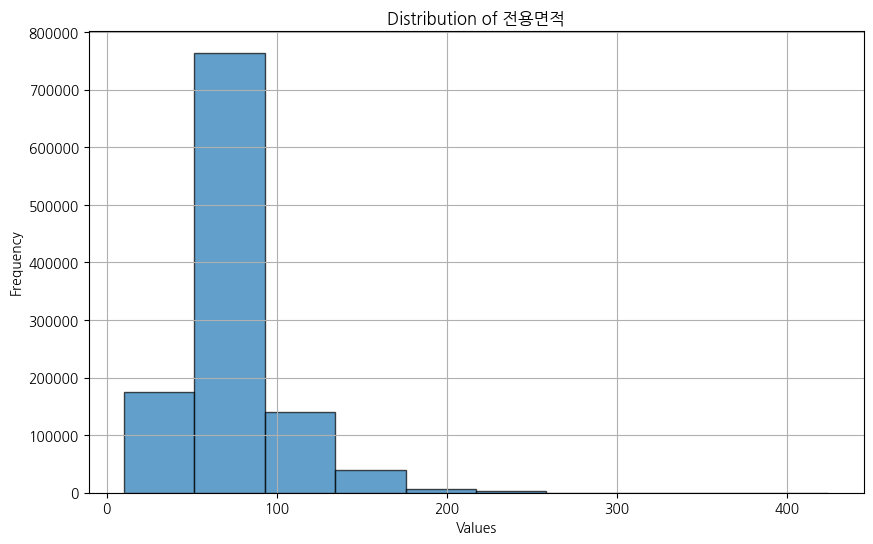

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(data['전용면적'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

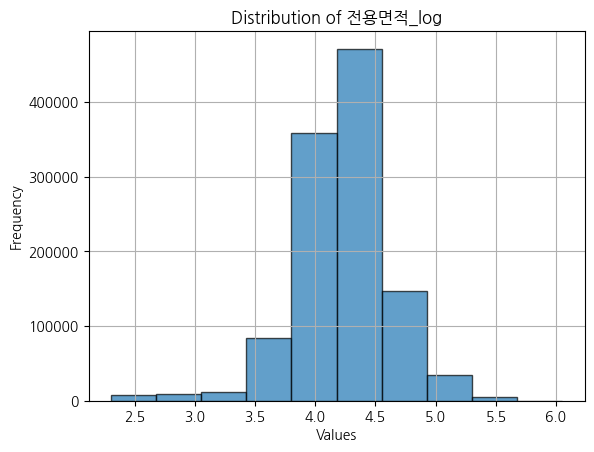

In [4]:
data['전용면적_log'] = np.log(data['전용면적'])

plt.hist(data['전용면적_log'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_log')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

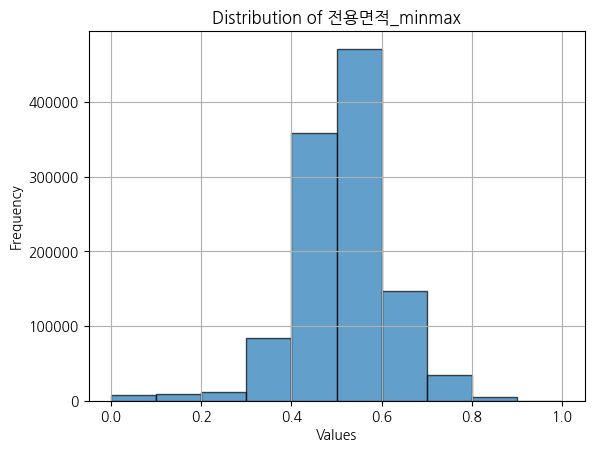

In [5]:
scaler = MinMaxScaler()
data['전용면적_minmax'] = scaler.fit_transform(data['전용면적_log'].values.reshape(-1, 1))

plt.hist(data['전용면적_minmax'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 전용면적_minmax')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
# data['전용면적'] = data['전용면적_minmax']
data = data.drop(columns=['전용면적_log', '전용면적_minmax'])
print(data.columns)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', '거래유형', 'k-건설사(시공사)', '좌표X', '좌표Y', 'target', '세대별_주차대수',
       'is_test'],
      dtype='object')


## 2-3.계약날짜

부동산 거래를 한 시점이므로 금리나 GDP와 같은 데이터와 연계하는데 사용가능할듯. 대신 추가 정보가 데이터프레임에 추가되고 나서는 삭제하거나 시계열로 다루는 기준이 될 뿐 학습에 직접적으로 반영되지는 않을듯

In [7]:
data['계약년월'].info

<bound method Series.info of 0       201712
1       201712
2       201712
3       201801
4       201801
         ...  
9267    202307
9268    202307
9269    202308
9270    202309
9271    202309
Name: 계약년월, Length: 1128094, dtype: int64>

In [8]:
data['계약년월'] = pd.to_datetime(data['계약년월'], format='%Y%m', errors='coerce')
data['계약년월'] = data['계약년월'].dt.to_period('M')

In [9]:
print(data['계약년월'].unique())

<PeriodArray>
['2017-12', '2018-01', '2018-03', '2018-04', '2018-06', '2018-07', '2018-08',
 '2018-09', '2017-10', '2017-11',
 ...
 '2007-01', '2007-02', '2007-04', '2007-05', '2007-06', '2007-08', '2007-09',
 '2023-07', '2023-08', '2023-09']
Length: 201, dtype: period[M]


In [10]:
oldest_date = data['계약년월'].min()
most_recent_date = data['계약년월'].max()

print(oldest_date, most_recent_date)

2007-01 2023-09


건축년도가 오래되었어도 가격이 안빠지는 것을 볼 수 있다. 따라서 해당 부동산이 어디에 있는지가 더 중요하다고 해석할 수 있을 듯

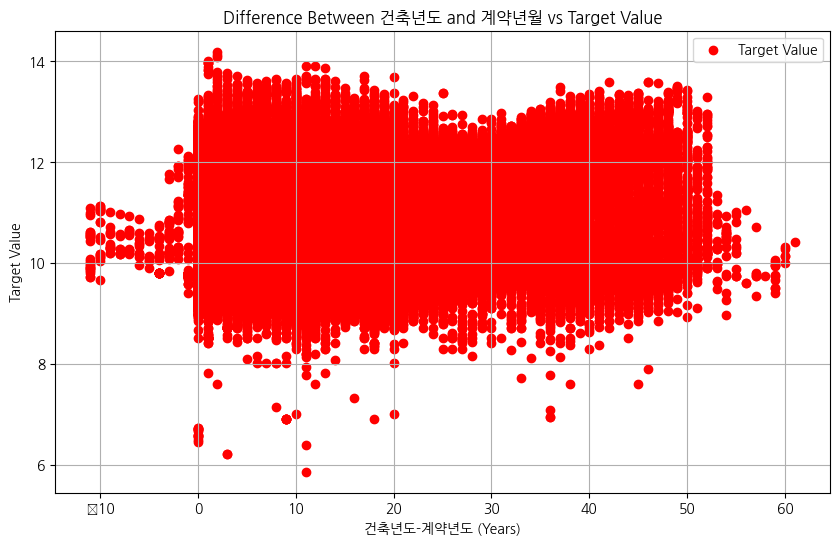

In [11]:
data['건축년도-계약년도'] = (data['계약년월'].dt.year - data['건축년도'])

# 차이값과 타겟 컬럼값 시각화
plt.figure(figsize=(10, 6))
plt.scatter(data['건축년도-계약년도'], np.log(data['target']), c='red', label='Target Value')
# plt.plot(data['건축년도-계약년도'], np.log(data['target']), c='blue')

plt.title('Difference Between 건축년도 and 계약년월 vs Target Value')
plt.xlabel('건축년도-계약년도 (Years)')
plt.ylabel('Target Value')
plt.grid(True)
plt.legend()
plt.show()

15.974996764454026


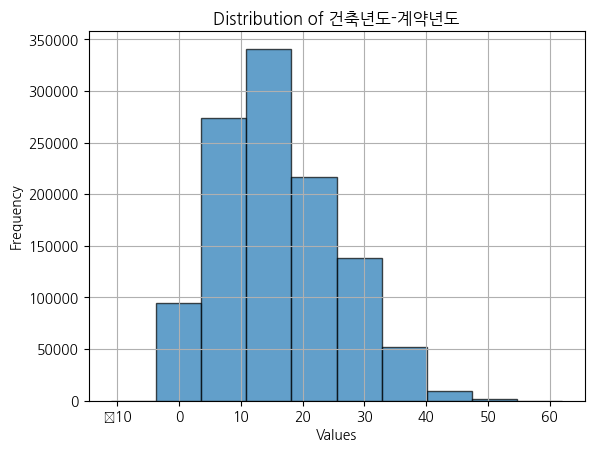

In [12]:
print(data['건축년도-계약년도'].mean())
plt.hist(data['건축년도-계약년도'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 건축년도-계약년도')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 2-4.층

In [13]:
print(data['층'].min(), data['층'].max())
print(data['층'].value_counts())
print(list(data['층'].unique()))

-4 69
층
 5     82748
 4     82633
 3     81089
 2     77575
 6     74215
       ...  
 65        6
 67        6
 68        6
-4         4
 69        2
Name: count, Length: 73, dtype: int64
[3, 4, 5, 2, 1, 8, 6, 10, 12, 14, 11, 15, 19, 16, 18, 21, 7, 13, 9, 22, 20, 26, 17, 24, 29, 23, 25, 27, 34, 30, 32, 28, 46, 44, 45, 35, 38, 37, 40, 36, 48, 54, 43, 42, 60, 57, 33, 49, 55, 53, 47, 41, 52, 39, 51, 68, 58, 59, 62, 63, 31, 50, -2, -1, 56, 65, 66, 67, 69, -3, -4, 64, 61]


-4 69


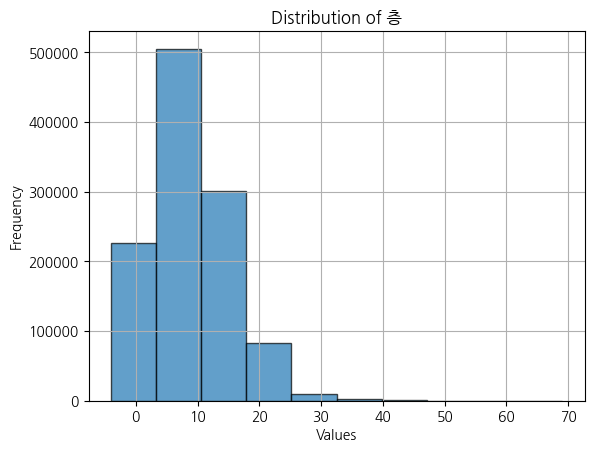

In [14]:
print(data['층'].min(), data['층'].max())

plt.hist(data['층'], edgecolor='k', alpha=0.7)
plt.title('Distribution of 층')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

-5.199337582605575 5.19933758270342


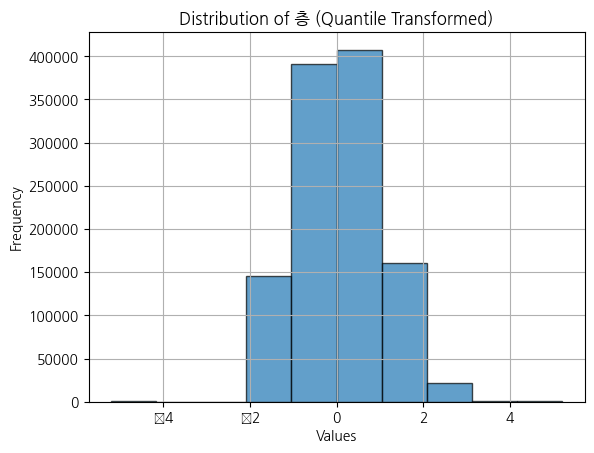

In [15]:
qt = QuantileTransformer(output_distribution='normal')
data['층_qt'] = qt.fit_transform(data[['층']])
print(data['층_qt'].min(), data['층_qt'].max())

plt.hist(data['층_qt'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 층 (Quantile Transformed)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [16]:
data = data.drop(columns=['층_qt'])

# qt = QuantileTransformer(output_distribution='normal')
# data['층'] = qt.fit_transform(data[['층']])

print(data.columns)

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', '거래유형', 'k-건설사(시공사)', '좌표X', '좌표Y', 'target', '세대별_주차대수',
       'is_test', '건축년도-계약년도'],
      dtype='object')


## 2-6.건축년도

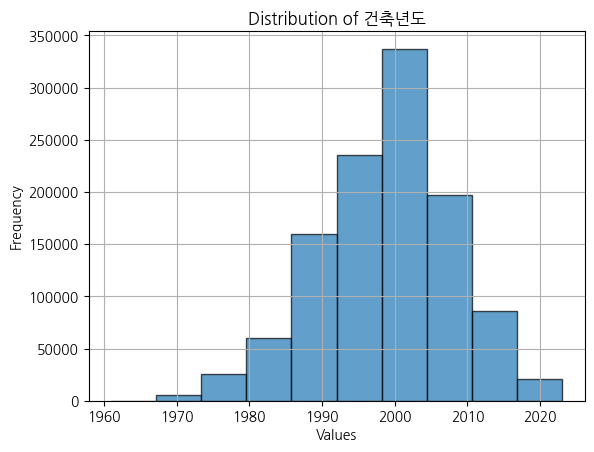

In [17]:
plt.hist(data['건축년도'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribution of 건축년도')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
data.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', '거래유형', 'k-건설사(시공사)', '좌표X', '좌표Y', 'target', '세대별_주차대수',
       'is_test', '건축년도-계약년도'],
      dtype='object')

In [19]:
data = data.drop(columns=['층', '거래유형'])

In [20]:
data.columns

Index(['시군구', '번지', '아파트명', '전용면적', '계약년월', '건축년도', '도로명', '해제사유발생일', '등기신청일자',
       'k-건설사(시공사)', '좌표X', '좌표Y', 'target', '세대별_주차대수', 'is_test',
       '건축년도-계약년도'],
      dtype='object')

In [21]:
train_df = data[data['is_test'] == 0]
test_df = data[data['is_test'] == 1]

train_df = train_df.drop(columns=['is_test'])
test_df = test_df.drop(columns=['is_test', 'target'])
print(train_df.shape, test_df.shape)

train_df.to_csv(f'{data_path}/new/new_train_ver4.csv', index=False)
test_df.to_csv(f'{data_path}/new/new_test_ver4.csv', index=False)

(1118822, 15) (9272, 14)
